In [1]:
import numpy as np
import casadi as ca
from acrobotics.util import get_default_axes3d
from acrobotics.recources.robots import Kuka
from acrobotics.geometry import Collection, Shape

robot = Kuka()

table = Shape(0.5, 0.25, 0.1)
table_tf = np.array([[1, 0, 0, 0.80],
                    [0, 1, 0, 0.25],
                    [0, 0, 1, 0.13],
                    [0, 0, 0, 1]])

box_up = Shape(0.1, 0.1, 0.1)
box_lo = Shape(0.1, 0.1, 0.1)

box_up_tf = np.array([[1, 0, 0, 0.80],
                    [0, 1, 0, -0.1],
                    [0, 0, 1, 0.32],
                    [0, 0, 0, 1]])
box_lo_tf = np.array([[1, 0, 0, 0.80],
                    [0, 1, 0, -0.1],
                    [0, 0, 1, 0.08],
                    [0, 0, 0, 1]])

# scene = Collection([table], [table_tf])
scene = Collection([table, box_up, box_lo], [table_tf, box_up_tf, box_lo_tf])

N = 20 # path discretization
# TASK: the end-effector path (no orientation)
xp = np.ones(N) * 0.8
yp = np.linspace(-0.2, 0.2, N)
zp = np.ones(N) * 0.2

In [2]:
%matplotlib qt
fig, ax = get_default_axes3d([0, 1], [-0.5, 0.5], [0, 1])

ax.set_axis_off()
# ax.view_init(25, -25)# settinsg to show obstacles
ax.view_init(25, -40)

# ax.scatter(xp, yp, zp)
robot.plot(ax, [0, 1.5, 0, 0, 0, 0], c='k')
# scene.plot(ax, c='g')
# scene.s[1].plot(ax, tf=box_up_tf, c='k')
# scene.s[2].plot(ax, tf=box_lo_tf, c='r')




## Extract convex polyhedron matrices from kuka robot and scene
http://mathworld.wolfram.com/ConvexPolyhedron.html
https://gitlab.mech.kuleuven.be/u0100037/path_planning_manipulator/blob/master/geometry/optimization.py


In [3]:
pol_mat_a = []
pol_mat_b = []

# assume all links have only one shape
for link in robot.links:
    s = link.geometry.shapes[0]
    Ai = s.get_normals(np.eye(4))
    bi = 0.5 * np.array([s.dx, s.dx, s.dy, s.dy, s.dz, s.dz])
    
    pol_mat_a.append(Ai)
    pol_mat_b.append(bi)

pol_mat_a_scene = []
pol_mat_b_scene = []

# assume all links have only one shape
for s, tf in zip(scene.shapes, scene.tf_s):
    Ai = s.get_normals(np.eye(4))
    bi = 0.5 * np.array([s.dx, s.dx, s.dy, s.dy, s.dz, s.dz])
    
    Ai = np.dot(Ai, tf[:3, :3].T)
    bi = bi + np.dot(Ai, tf[:3, 3])
    
    pol_mat_a_scene.append(Ai)
    pol_mat_b_scene.append(bi)

## Forward kinematics for all links using DH convention

In [4]:
from casadi import cos, sin, dot

def get_link_relative_transform(link, qi):
        
    a, alpha, d, theta = link.dh.a, link.dh.alpha, link.dh.d, qi

    c_t, s_t = cos(theta), sin(theta)
    c_a, s_a = cos(alpha), sin(alpha)

    row1 = ca.hcat([c_t, -s_t * c_a,  s_t * s_a,  a * c_t])
    row2 = ca.hcat([s_t,  c_t * c_a, -c_t * s_a,  a * s_t])
    row3 = ca.hcat([0, s_a, c_a, d])
    row4 = ca.hcat([0, 0, 0, 1])

    return ca.vcat([row1, row2, row3, row4])

def fk_all_links(links, q, tf_base=np.eye(4)):
    """ Return link frames (not base or tool)
    """
    tf_links = []
    T = tf_base
    for i in range(len(links)):
        Ti = get_link_relative_transform(links[i], q[i])
        T = T @ Ti
        tf_links.append(T)
    return tf_links

## forward kinematics for end-effector in separate function just because

In [5]:
def fk_kuka2(q):
    q1, q2, q3, q4, q5, q6 = q[0], q[1], q[2], q[3], q[4], q[5]
    a1=0.18; a2=0.6; d4=0.62; d6=0.115
    T = np.array([
[((sin(q1)*sin(q4) + cos(q1)*cos(q4)*cos(q2 + q3))*cos(q5) - sin(q5)*sin(q2 + q3)*cos(q1))*cos(q6) + (sin(q1)*cos(q4) - sin(q4)*cos(q1)*cos(q2 + q3))*sin(q6), -((sin(q1)*sin(q4) + cos(q1)*cos(q4)*cos(q2 + q3))*cos(q5) - sin(q5)*sin(q2 + q3)*cos(q1))*sin(q6) + (sin(q1)*cos(q4) - sin(q4)*cos(q1)*cos(q2 + q3))*cos(q6), (sin(q1)*sin(q4) + cos(q1)*cos(q4)*cos(q2 + q3))*sin(q5) + sin(q2 + q3)*cos(q1)*cos(q5), a1*cos(q1) + a2*cos(q1)*cos(q2) + d4*sin(q2 + q3)*cos(q1) + d6*((sin(q1)*sin(q4) + cos(q1)*cos(q4)*cos(q2 + q3))*sin(q5) + sin(q2 + q3)*cos(q1)*cos(q5))],
[((sin(q1)*cos(q4)*cos(q2 + q3) - sin(q4)*cos(q1))*cos(q5) - sin(q1)*sin(q5)*sin(q2 + q3))*cos(q6) - (sin(q1)*sin(q4)*cos(q2 + q3) + cos(q1)*cos(q4))*sin(q6), -((sin(q1)*cos(q4)*cos(q2 + q3) - sin(q4)*cos(q1))*cos(q5) - sin(q1)*sin(q5)*sin(q2 + q3))*sin(q6) - (sin(q1)*sin(q4)*cos(q2 + q3) + cos(q1)*cos(q4))*cos(q6), (sin(q1)*cos(q4)*cos(q2 + q3) - sin(q4)*cos(q1))*sin(q5) + sin(q1)*sin(q2 + q3)*cos(q5), a1*sin(q1) + a2*sin(q1)*cos(q2) + d4*sin(q1)*sin(q2 + q3) + d6*((sin(q1)*cos(q4)*cos(q2 + q3) - sin(q4)*cos(q1))*sin(q5) + sin(q1)*sin(q2 + q3)*cos(q5))],
[                                                                (sin(q5)*cos(q2 + q3) + sin(q2 + q3)*cos(q4)*cos(q5))*cos(q6) - sin(q4)*sin(q6)*sin(q2 + q3),                                                                 -(sin(q5)*cos(q2 + q3) + sin(q2 + q3)*cos(q4)*cos(q5))*sin(q6) - sin(q4)*sin(q2 + q3)*cos(q6),                                     sin(q5)*sin(q2 + q3)*cos(q4) - cos(q5)*cos(q2 + q3),                                                                  a2*sin(q2) - d4*cos(q2 + q3) + d6*(sin(q5)*sin(q2 + q3)*cos(q4) - cos(q5)*cos(q2 + q3))],
[                                                                                                                                                           0,                                                                                                                                                             0,                                                                                       0,                                                                                                                                                        1]])
    return T

# Formulate optimization problem

In [6]:
N = 20 # path discretization
ndof = robot.ndof  #  robot degrees of freedom
nobs = len(scene.shapes)  #  number of obstacles

# number of planes in the polyhedrons (the same for all shapes, robot and obstacles!)
S = 6

# collision tolerance
eps = 1e-6

opti = ca.Opti()

q = opti.variable(N, 6)  #  joint variables along path

# dual variables arranged in convenient lists to acces with indices
lam = [[[opti.variable(S) for j in range(nobs)] for i in range(ndof)] for k in range(N)]
mu =  [[[opti.variable(S) for j in range(nobs)] for i in range(ndof)] for k in range(N)]

### Collision constraints

In [7]:
def col_con(lam, mu, Ar, Ao, br, bo):
    opti.subject_to( -dot(br, lam) - dot(bo, mu) >= eps)
    opti.subject_to(        Ar.T @ lam + Ao.T @ mu == 0.0)
    opti.subject_to( dot(Ar.T @ lam, Ar.T @ lam) <= 1.0)
    opti.subject_to(                         lam >= 0.0)
    opti.subject_to(                          mu >= 0.0)


for k in range(N):
    fk = fk_all_links(robot.links, q[k, :])
    for i in range(ndof):
        Ri = fk[i][:3, :3]
        pi = fk[i][:3, 3]
        for j in range(nobs):
            Ar = pol_mat_a[i] @ Ri.T
            br = pol_mat_b[i] + Ar @ pi
            col_con(lam[k][i][j], mu[k][i][j],
                    Ar,
                    pol_mat_a_scene[j],
                    br,
                    pol_mat_b_scene[j])

### Objective and path

In [8]:
V = ca.sum1( (ca.sum2(q[:-1, :] - q[1:, :])**2 ))# + 0.05* ca.sumsqr(q) #+ 1 / ca.sum1(q[:, 4]**2)

opti.minimize(V)

for i in range(N):
    Ti = fk_kuka2(q[i, :])
    opti.subject_to(xp[i] == Ti[0, 3])
    opti.subject_to(yp[i] == Ti[1, 3])
    opti.subject_to(zp[i] == Ti[2, 3])

opti.solver('ipopt');

In [9]:
%%capture
sol = opti.solve()

In [15]:
qp_sol = opti.value(q)

%matplotlib qt
fig, ax = get_default_axes3d([0, 1], [-0.5, 0.5], [0, 1])

ax.scatter(xp, yp, zp)
scene.plot(ax, c='g')
robot.animate_path(fig, ax, qp_sol)

ax.set_axis_off()
ax.view_init(24, 50)

## Plot path details

Questions:
How to choose N to get a realistic joint path for a robot?

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

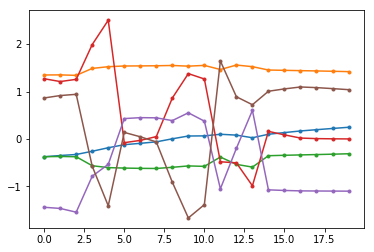

In [61]:
fig, ax = plt.subplots()

l = ax.plot(qp_sol, '.-')
# done

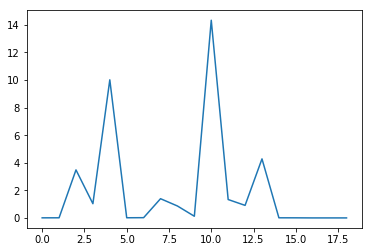

In [62]:
cost = np.sum((qp_sol[:-1] - qp_sol[1:])**2, 1)

plt.plot(cost)